# FASHION GAN #

## Dependencies ##

In [1]:
import os
import h5py
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
import pickle
import math
import sys

#Custom libraries
from Downsampling import GetSegmentationImageReady, OneHotEncodingImage, DownsizeAttributes, DownsampleImage, normalize_image
from Gans import Generator1, Discriminator1, Generator2, Discriminator2, initGans
import DeepFashDataset

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print("Using device: {}".format(device))
generator1, discriminator1, generator2, discriminator2 = initGans(device)

Using device: cuda:0


In [2]:
# Load images
import h5py
Data_G2 = h5py.File('Data/G2.h5', 'r')
segmentatedImages = Data_G2['b_']
# Load attributes
from scipy.io import loadmat
Data_matlab = loadmat('Data/language_original.mat')

## Preprocessing (Remove outcomment to run once) ## 

In [3]:
"""## Creates a new dataset

CreatedDataSet = h5py.File('Data/CreatedDataSet.h5', 'w')
print(type(CreatedDataSet))

## Creates new group
DownsampleGrp = CreatedDataSet.create_group("downsampledImg")
print(DownsampleGrp.name)

## Creates new dataset
DownsampleGrp.create_dataset("downsampledData", (Data_G2['b_'].shape[0], 4, 8, 8), dtype='i8')
#DownsampleGrp.create_dataset("downsampledOnehot", (Data_G2['b_'].shape[0], 4, 128, 128), dtype='i8')


downsampledData = CreatedDataSet['downsampledImg']["downsampledData"]
print(downsampledData.shape)


numberOfIter = downsampledData.shape[0]
for i in range(numberOfIter):
  if i % 5000 == 0:
    print("{} out of {}".format(i, numberOfIter))
  segmentatedImage = segmentatedImages[i]
  downsizedImage = DownsizeAttributes(segmentatedImage)
  oneHotEncodedImage = OneHotEncodingImage(downsizedImage[0], 4)
  #downsampledOnehot[i] = oneHotEncodedImage 
  downsampledImage = np.empty((4,8,8))
  downsampleSize =(8,8)
  downsampledImage[0] = DownsampleImage(oneHotEncodedImage[0], downsampleSize)
  downsampledImage[1] = DownsampleImage(oneHotEncodedImage[1], downsampleSize)
  downsampledImage[2] = DownsampleImage(oneHotEncodedImage[2], downsampleSize)
  downsampledImage[3] = DownsampleImage(oneHotEncodedImage[3], downsampleSize)
  downsampledData[i] = downsampledImage

print("Done")
CreatedDataSet.close()"""

'## Creates a new dataset\n\nCreatedDataSet = h5py.File(\'Data/CreatedDataSet.h5\', \'w\')\nprint(type(CreatedDataSet))\n\n## Creates new group\nDownsampleGrp = CreatedDataSet.create_group("downsampledImg")\nprint(DownsampleGrp.name)\n\n## Creates new dataset\nDownsampleGrp.create_dataset("downsampledData", (Data_G2[\'b_\'].shape[0], 4, 8, 8), dtype=\'i8\')\n#DownsampleGrp.create_dataset("downsampledOnehot", (Data_G2[\'b_\'].shape[0], 4, 128, 128), dtype=\'i8\')\n\n\ndownsampledData = CreatedDataSet[\'downsampledImg\']["downsampledData"]\nprint(downsampledData.shape)\n\n\nnumberOfIter = downsampledData.shape[0]\nfor i in range(numberOfIter):\n  if i % 5000 == 0:\n    print("{} out of {}".format(i, numberOfIter))\n  segmentatedImage = segmentatedImages[i]\n  downsizedImage = DownsizeAttributes(segmentatedImage)\n  oneHotEncodedImage = OneHotEncodingImage(downsizedImage[0], 4)\n  #downsampledOnehot[i] = oneHotEncodedImage \n  downsampledImage = np.empty((4,8,8))\n  downsampleSize =(8,8)\

In [4]:
## TODO: INDSÆT RNN PREPROCESSING

In [ ]:
downsampledData = h5py.File('Data/CreatedDataSet.h5', 'r')
Data_attributes = h5py.File('Data/Attributes.h5', 'r')

## Simple Sample ##

In [8]:
index = 1

realImage = Data_G2['ih'][index]
realSegmentatedImage = Data_G2['b_'][index]
from scipy.io import loadmat
Data_matlab = loadmat('Data/language_original.mat')
descriptionEng = Data_matlab["engJ"][index]
descriptionCodeJ = Data_matlab["codeJ"][index]
attributes = Data_attributes['df_final']["block0_values"][index]
downsampled = downsampledData['downsampledImg']["downsampledData"][index]

# Load generator1
generator1Loaded = pickle.load(open('E:\DTU\Deeplearning\models\generator1_20k_100epoch_new.sav', 'rb'))
generator2Loaded = pickle.load(open('E:\DTU\Deeplearning\models\generator2_10k_200epoch.sav', 'rb'))

torch.Size([7, 128, 128])


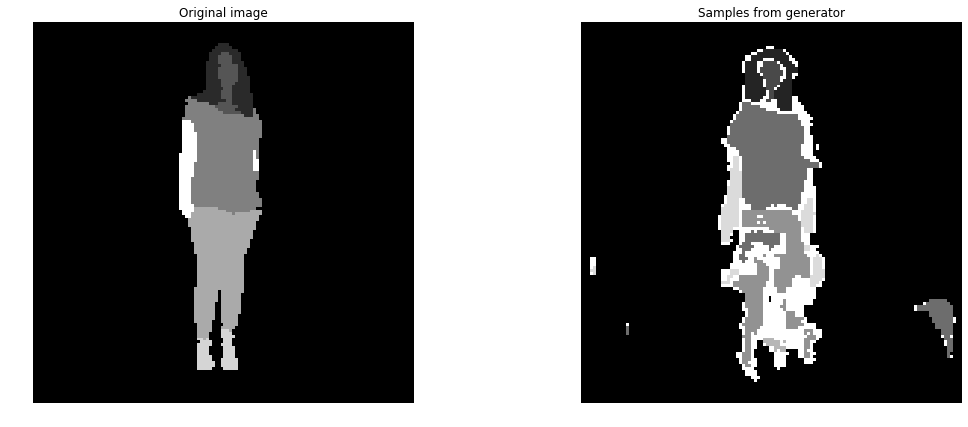

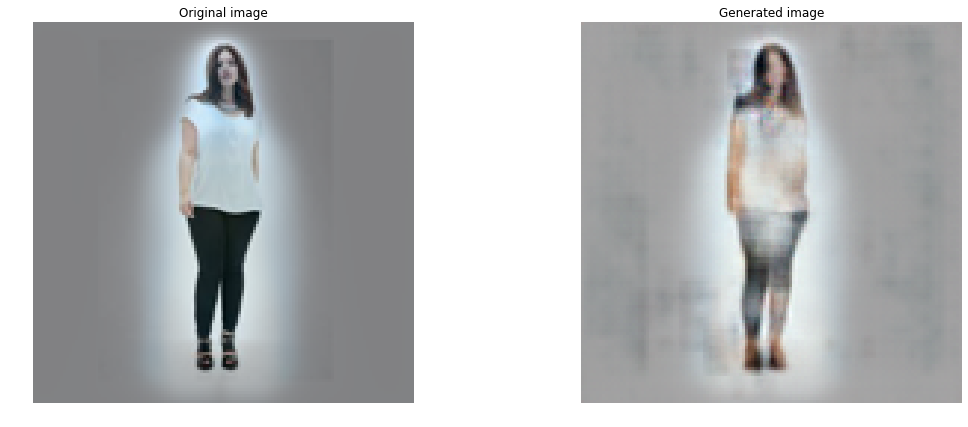

In [9]:
latent_dim = 100

realSegmentationImage_onehot = torch.from_numpy(OneHotEncodingImage(realSegmentatedImage, 7))[0].permute(2,0,1)
realSegmentationImage_onehot_true = Variable(realSegmentationImage_onehot.view(1, realSegmentationImage_onehot.shape[0], realSegmentationImage_onehot.shape[1], realSegmentationImage_onehot.shape[2])).to(device, dtype=torch.float)

attributes_tensor = torch.from_numpy(attributes)
downsampled_tensor = torch.from_numpy(downsampled)
attributes_true = Variable(attributes_tensor.view(1, attributes_tensor.shape[0], 1, 1)).to(device, dtype=torch.float) 
downsampled_true = Variable(downsampled_tensor.view(1, downsampled_tensor.shape[0], downsampled_tensor.shape[1], downsampled_tensor.shape[2])).to(device, dtype=torch.float)

with torch.no_grad():
  z = torch.randn(1, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake = generator1Loaded(z, downsampled_true, attributes_true)

fakeSegmentationImage = Variable(x_fake).to(device, dtype=torch.float)

x_fake = x_fake[0]

threshold = -0.5
print(x_fake.shape)
x_fake[0][x_fake[0] > threshold] = 0
x_fake[1][x_fake[1] > threshold] = 0
x_fake[2][x_fake[2] > threshold] = 0
x_fake[3][x_fake[3] > threshold] = 0
x_fake[4][x_fake[4] > threshold] = 0
x_fake[5][x_fake[5] > threshold] = 0
x_fake[6][x_fake[6] > threshold] = 0

x_fake[0][x_fake[0] < threshold] = 7
x_fake[1][x_fake[1] < threshold] = 6
x_fake[2][x_fake[2] < threshold] = 5
x_fake[3][x_fake[3] < threshold] = 4
x_fake[4][x_fake[4] < threshold] = 3
x_fake[5][x_fake[5] < threshold] = 2
x_fake[6][x_fake[6] < threshold] = 1


f, axarr = plt.subplots(1, 2, figsize=(18, 7))
ax = axarr[1]
ax.set_title('Generated Segmentation Image')
ax.axis('off')


summation = x_fake[0] + x_fake[1] + x_fake[2] + x_fake[3] + x_fake[4] + x_fake[5] + x_fake[6] 
ax.imshow(summation.T.cpu(), cmap='gray')

ax = axarr[0]
ax.set_title('Original Segmentation Image')
ax.axis('off')
#print(image)

summationReal = torch.from_numpy(realSegmentatedImage[0])
ax.imshow(summationReal.T.cpu(), cmap='gray')

#Image generating

with torch.no_grad():
  z = torch.randn(1, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake_img = generator2Loaded(z, realSegmentationImage_onehot_true, attributes_true)



f, axarr2 = plt.subplots(1, 2, figsize=(18, 7))

ax2 = axarr2[1]
ax2.set_title('Generated image')
ax2.axis('off')

summation = normalize_image(x_fake_img[0])
ax2.imshow(summation.T.cpu(), cmap='gray')

ax2 = axarr2[0]
ax2.set_title('Original image')
ax2.axis('off')

imagetest = normalize_image(torch.from_numpy(realImage))

ax2.imshow(imagetest.T.cpu(), cmap='gray')


## Training Gan 1 ##

### Dataloader ###

In [ ]:
batch_size = 64

dataset = DeepFashDataset.DatasetFirst(Data_G2, downsampledData, Data_attributes)

num_train = 20000
indices = list(range(num_train))
split = int(math.floor(0.1 * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=cuda, sampler = train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=cuda, sampler = test_sampler)


### Training ###

In [ ]:
import time

loss = torch.nn.BCELoss()
loss_seg = torch.nn.NLLLoss()

discriminator_loss, generator_loss = [], []

lambda_fake = 0.9
lambda_mismatch = 1 - lambda_fake

num_epochs = 100
latent_dim = 100

discriminator_optim = torch.optim.Adam(discriminator1.parameters(), 0.002, betas=(0.5, 0.999))
generator_optim = torch.optim.Adam(generator1.parameters(), 0.002, betas=(0.5, 0.999))

i = 0


for epoch in range(num_epochs):
  batch_d_loss, batch_g_loss = [], []
  start = time.time()
  for attributes, downsampled, segmentatedImage, segmentatedImage_onehot, wrong_data, wrong_processed, wrong_onehot in train_loader:
    i = i + 1
    batch_size = attributes.size(0)
    # True data is given label 1, while fake data is given label 0
    true_label = torch.ones(batch_size, 1, 1, 1).to(device)
    true_label_step4 = torch.ones(batch_size, 1, 1, 1).to(device)
    fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)
    fake_labelStep3 = torch.zeros(batch_size, 1, 1, 1).to(device)

    attributes = attributes.view(attributes.size(0), attributes.size(1), 1, 1)
    
    
    ## Discriminator ##
    
    discriminator_optim.zero_grad()
    
    attributesX4 = torch.cat((attributes, attributes, attributes, attributes), 2)
    attributesX4 = torch.cat((attributesX4, attributesX4, attributesX4, attributesX4), 3)

    attributes_true = Variable(attributes).to(device, dtype=torch.float)
    attributesX4_true = Variable(attributesX4).to(device, dtype=torch.float)       
    downsampled_true = Variable(downsampled).to(device, dtype=torch.float)
    segmentatedImage_true = Variable(segmentatedImage).to(device, dtype=torch.float)
    segmentatedImage_OneHot_true = Variable(segmentatedImage_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    segmentatedImage_OneHot_Wrong = Variable(wrong_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    downsampled_wrong = Variable(wrong_processed).to(device, dtype=torch.float)
    
    #Step 1 real data through discriminator and backprobagate.
    output = discriminator1(segmentatedImage_OneHot_true, downsampled_true, attributesX4_true)
    
    error_true = loss(output, true_label)
    
    error_true.backward()
    
    ### Step 2 wrong data through discriminator

    output = discriminator1(segmentatedImage_OneHot_Wrong ,downsampled_wrong,attributesX4_true)
    
    error_notmatch = lambda_mismatch * loss(output, fake_label) 
    
    error_notmatch.backward()
    
    step2 = step2 + (time.time() - step2start)
    
    # Step 3 noise through generator.
    z = torch.randn(batch_size, latent_dim, 1, 1)
    z = Variable(z).to(device, dtype=torch.float)
    attributes_true_G = Variable(attributes).to(device, dtype=torch.float)     
    downsampled_true_G = Variable(downsampled).to(device, dtype=torch.float)
    attributesX4_true_test = Variable(attributesX4).to(device, dtype=torch.float) 

    G1 = generator1(z, downsampled_true_G, attributes_true_G)
    
    output = discriminator1(G1.detach(), downsampled_true_G.detach(), attributesX4_true_test.detach())
    
    error_fake = lambda_fake * loss(output, fake_labelStep3)
    error_fake.backward()
    discriminator_optim.step()
    
    
    ## GENERATOR ##
    # Step 4 send the data through discriminator and update again and propagate generator error and update weights
    generator_optim.zero_grad()
    output = discriminator1(G1, downsampled_true_G, attributesX4_true_test)

    error_generator = loss(output, true_label_step4)
    
    target = Variable(segmentatedImage_true).to(device,dtype=torch.long)
    error_seg = 50*loss_seg(G1,target)
    
    error_total = error_generator + error_seg
    
    error_total.backward()
    
    generator_optim.step()
    
    
    error1 = (error_true + error_fake + error_true).item()
    error2 = (error_total).item()
    
    batch_d_loss.append(error1)
    batch_g_loss.append(error2)
    
  batch_d_loss_mean = np.mean(batch_d_loss)
  batch_g_loss_mean = np.mean(batch_g_loss)
  if epoch % 5 == 0:
      print("Epoch tid: {}".format(time.time() - start))
      print("Epoch {}:".format(epoch))
      print("D loss: {}".format(batch_d_loss_mean))
      print("G loss: {}".format(batch_g_loss_mean))

  discriminator_loss.append(batch_d_loss_mean)
  generator_loss.append(batch_g_loss_mean)


# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)

ax.legend(['Discriminator'])

ax = axarr[1]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Generator']) 

### Results

In [ ]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)

ax.legend(['Discriminator'])

ax = axarr[1]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Generator']) 

In [ ]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Latent space samples
ax = axarr[1]
ax.set_title('Generated Segmentation Image')
ax.axis('off')

# Generate data
with torch.no_grad():
  z = torch.randn(64, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake = generator1(z, downsampled_true, attributes_true)

index = 5

x_fake = x_fake[index]
#Minus since it's negative log likelihood that is used
threshold = -0.5
x_fake[0][x_fake[0] > threshold] = 0
x_fake[1][x_fake[1] > threshold] = 0
x_fake[2][x_fake[2] > threshold] = 0
x_fake[3][x_fake[3] > threshold] = 0
x_fake[4][x_fake[4] > threshold] = 0
x_fake[5][x_fake[5] > threshold] = 0
x_fake[6][x_fake[6] > threshold] = 0

x_fake[0][x_fake[0] < threshold] = 7
x_fake[1][x_fake[1] < threshold] = 6
x_fake[2][x_fake[2] < threshold] = 5
x_fake[3][x_fake[3] < threshold] = 4
x_fake[4][x_fake[4] < threshold] = 3
x_fake[5][x_fake[5] < threshold] = 2
x_fake[6][x_fake[6] < threshold] = 1

summation = x_fake[0] + x_fake[1] + x_fake[2] + x_fake[3] + x_fake[4] + x_fake[5] + x_fake[6] 
ax.imshow(summation.T.cpu(), cmap='gray')

ax = axarr[0]
ax.set_title('Original Segmentation Image')
ax.axis('off')
realSegmentation = segmentatedImage_true[index]

ax.imshow(realSegmentation.T.cpu(), cmap='gray')

## Training Gan 2

## Dataloader

In [ ]:
batch_size = 64

datasetTwo = DeepFashDataset.DatasetSecond(Data_G2, downsampledData, Data_attributes)

num_train = 20000
indices = list(range(num_train))
split = int(math.floor(0.1 * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(valid_idx)

train_loader2 = DataLoader(datasetTwo, batch_size=batch_size, pin_memory=cuda, sampler = train_sampler)
test_sampler2 = DataLoader(datasetTwo, batch_size=batch_size, pin_memory=cuda, sampler = test_sampler)

## Training

In [ ]:
loss = torch.nn.BCELoss()
loss_img = torch.nn.L1Loss()
discriminator_loss, generator_loss = [], []

num_epochs = 80
lambda_fake = 0.9
lambda_mismatch = 1 - lambda_fake
latent_dim = 100

discriminator_optim2 = torch.optim.Adam(discriminator2.parameters(), 2e-4, betas=(0.5, 0.999))
generator_optim2 = torch.optim.Adam(generator2.parameters(), 2e-4, betas=(0.5, 0.999))

for epoch in range(num_epochs):
  batch_d_loss2, batch_g_loss2 = [], []
  i = 0
  start = time.time()
  for attributes, data_processed, image, wrong_data, wrong_processed, segmentatedImage_onehot, segmentatedImage_onehot_wrong in train_loader2:
    batch_size = attributes.size(0)
    # True data is given label 1, while fake data is given label 0
    true_label = torch.ones(batch_size, 1, 1, 1).to(device)
    fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)
    attributes = attributes.view(attributes.size(0), attributes.size(1), 1, 1)
    
    ## Discriminator ##
    
    discriminator_optim2.zero_grad()
    
    attributesX4 = torch.cat((attributes, attributes, attributes, attributes), 2)
    attributesX4 = torch.cat((attributesX4, attributesX4, attributesX4, attributesX4), 3)

    attributes_true = Variable(attributes).to(device, dtype=torch.float)
    attributesX4_true = Variable(attributesX4).to(device, dtype=torch.float)
    image_true = Variable(image).to(device, dtype=torch.float)
    image_wrong = Variable(wrong_data).to(device, dtype=torch.float)
    downsampled_wrong = Variable(wrong_processed).to(device, dtype=torch.float)
    segmentatedImage_onehot_true = Variable(segmentatedImage_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    segmentatedImage_onehot_wrong2 = Variable(segmentatedImage_onehot_wrong.permute(0,3,1,2)).to(device, dtype=torch.float)
    
    #Step 1 real data through discriminator and backprobagate.

    output = discriminator2(image_true, segmentatedImage_onehot_true, attributesX4_true)
    
    error_true = loss(output, true_label)
    error_true.backward()

    ### Step 2
    output = discriminator2(image_wrong ,segmentatedImage_onehot_wrong2,attributesX4_true)
    
    error_notmatch = lambda_mismatch * loss(output, fake_label) 
    
    error_notmatch.backward()
    
    ###

    # Step 3 noise through generator.
    z = torch.randn(batch_size, latent_dim, 1, 1)
    z = Variable(z).to(device, dtype=torch.float)
    attributes_true_G = Variable(attributes).to(device, dtype=torch.float)     
    segmentatedImage_true_G = Variable(segmentatedImage_onehot.permute(0,3,1,2)).to(device, dtype=torch.float)
    G2 = generator2(z, segmentatedImage_true_G, attributes_true_G)


    # send the data through discriminator and update

    #downsampled_G_Var = Variable(test2).to(device, dtype=torch.float)
    attributesX4_true_test = Variable(attributesX4).to(device, dtype=torch.float)   

    output = discriminator2(G2.detach(), segmentatedImage_true_G.detach(), attributesX4_true_test.detach())


    error_fake = lambda_fake * loss(output, fake_label)
    error_fake.backward()
    discriminator_optim2.step()

    ## GENERATOR 2 ##
    
    # Step 4 send the data through discriminator and update again and propagate generator error and update weights
    generator_optim2.zero_grad()
    output = discriminator2(G2, segmentatedImage_true_G, attributesX4_true_test)

    error_generator = loss(output, true_label)
    
    ## error sequence
    target = Variable(image_true).to(device,dtype=torch.float)
    error_seg = 100*loss_img(G2,target)
    error_total = error_generator + error_seg
    error_total.backward()
    
    generator_optim2.step()
    
    error1 = ((error_true + error_fake + error_true)/2).item()
    error2 = (error_total).item()
    
    batch_d_loss2.append(error1)
    batch_g_loss2.append(error2)
    
  batch_d_loss_mean = np.mean(batch_d_loss2)
  batch_g_loss_mean = np.mean(batch_g_loss2)
    
  if epoch % 5 == 0:
    print("Epoch tid: {}".format(time.time() - start))
    print("Epoch {}:".format(epoch))
    print("D loss: {}".format(batch_d_loss_mean))
    print("G loss: {}".format(batch_g_loss_mean))


  discriminator_loss.append(batch_d_loss_mean)
  generator_loss.append(batch_g_loss_mean)

### Results

In [ ]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)

ax.legend(['Discriminator'])

ax = axarr[1]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Generator'])   

In [ ]:
# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# Latent space samples
ax = axarr[1]
ax.set_title('Samples from generator')
ax.axis('off')

# Generate data
with torch.no_grad():
  z = torch.randn(1, latent_dim, 1, 1)
  z = Variable(z, requires_grad=False).cpu().to(device)
  x_fake = generator2(z, segmentatedImage_onehot_true, attributes_true)

index = 0

ax = axarr[1]
ax.set_title('Generated image')
ax.axis('off')

summation = normalize_pictures(x_fake[index])
ax.imshow(summation.T.cpu(), cmap='gray')

ax = axarr[0]
ax.set_title('Original image')
ax.axis('off')

imagetest = torch.from_numpy(image)
imagetest = normalize_pictures(imagetest)
ax.imshow(imagetest.T.cpu(), cmap='gray')